In [1]:
pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Global Food Prices Database

In [3]:
custom_palette = [
    "#A8D5BA", "#B5D8A9", "#C4E3B2", "#D4E8C5", "#E1EDD2",  # 柔和绿色
    "#9DC183", "#A7C96E", "#B2D47B", "#BEDD85", "#CAE78E",  # 叶绿、浅草绿
    "#D9E3A3", "#E2E6B6", "#ECEAC9", "#F5EEDC", "#F8F4E8"  # 米色、浅黄绿色
    "#A78D6D", "#B5987A", "#C3A68A", "#D2B69B", "#E0C5AD",  # 棕色系（麦色、土色）
    "#9F8860", "#AC9570", "#B8A17F", "#C4AD8E", "#D0B89D",  # 木质棕色
    "#DAC5AE", "#E5D1BF", "#EFE0D0", "#F9ECE1", "#FAF5ED"   # 浅奶咖色
]


In [42]:
df = pd.read_csv("fao_data_crops_data.csv")
display(df.head(2))
df.info()

country_or_area         element    year unit    value          category
0      Americas +  Area Harvested  2007.0   Ha  49404.0  agave_fibres_nes
1      Americas +  Area Harvested  2006.0   Ha  49404.0  agave_fibres_nes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   country_or_area  1048575 non-null  object 
 1   element          1048111 non-null  object 
 2   year             1048111 non-null  float64
 3   unit             1048111 non-null  object 
 4   value            1048111 non-null  float64
 5   category         1048575 non-null  object 
dtypes: float64(2), object(4)
memory usage: 48.0+ MB


In [43]:
dfland = pd.read_csv("fao_data_land_data.csv")
display(dfland.head(2))
dfland.info()

country_or_area    year  landvalue value_footnotes       landcategory
0     Afghanistan  2006.0    38659.0              Fm  agricultural_area
1     Afghanistan  2005.0    38515.0              Fm  agricultural_area

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104216 entries, 0 to 104215
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_or_area  68995 non-null  object 
 1   year             68870 non-null  float64
 2   landvalue        68870 non-null  float64
 3   value_footnotes  68869 non-null  object 
 4   landcategory     68995 non-null  object 
dtypes: float64(2), object(3)
memory usage: 4.0+ MB


Data Cleaning

In [ ]:
def fill_zero_values(group):

    zero_indices = group[group['value'] == 0].index
    for idx in zero_indices:
        current_year = group.loc[idx, 'year']
        previous_year_data = group[group['year'] < current_year].tail(1)['value']
        next_year_data = group[group['year'] > current_year].head(1)['value']
        if not previous_year_data.empty and not next_year_data.empty:
            avg_value = (previous_year_data.values[0] + next_year_data.values[0]) / 2
        elif not previous_year_data.empty:
            avg_value = previous_year_data.values[0]
        elif not next_year_data.empty:
            avg_value = next_year_data.values[0]
        else:
            avg_value = np.nan
        group.loc[idx, 'value'] = avg_value
    return group
df = df.groupby(['country_or_area', 'element', 'category']).apply(fill_zero_values).reset_index(drop=True)

print(df.head())

Data segmentation

In [5]:
df_region = df[df['country_or_area'].str.endswith('+')] 
df_total = df[df['category'].str.endswith('total')] 


<Figure size 2000x800 with 0 Axes>

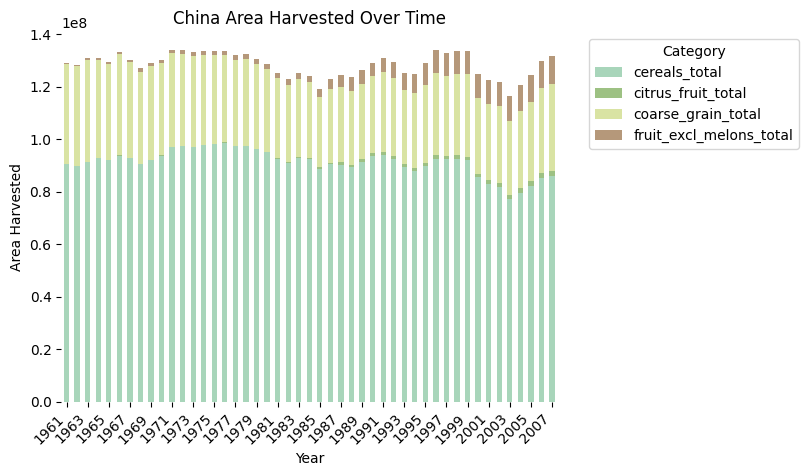

In [25]:

df1 = df_total[
    (df_total['country_or_area'] == 'China') & 
    (df_total['element'] == 'Area Harvested')
]

# 透视表
df_pivot = df1.pivot_table(index='year', columns='category', values='value', aggfunc='sum', fill_value=0)
df_pivot.index = df_pivot.index.astype(int)
# 确保颜色数足够
num_categories = len(df_pivot.columns)
colors = custom_palette[::5][:num_categories]  # 每隔 5 个颜色并限制颜色数量

# 画图
plt.figure(figsize=(20, 8))  # 宽度调整为 20，高度 8，避免过度拉伸
ax = df_pivot.plot(kind='bar', stacked=True, color=colors)  # ✅ 使用自定义颜色

# 轴标签
plt.xlabel('Year')
plt.ylabel('Area Harvested')

# 图例
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# 旋转 x 轴标签并优化间隔
ax.set_xticks(ax.get_xticks()[::2])  # 每隔一个标签显示一次
ax.set_xticklabels(df_pivot.index[::2], rotation=45, ha='right')
ax = plt.gca()  # 获取当前坐标轴
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)  
ax.spines['bottom'].set_visible(False) 
ax.spines['left'].set_visible(False)   
plt.title('China Area Harvested Over Time')
# 显示图像
plt.show()


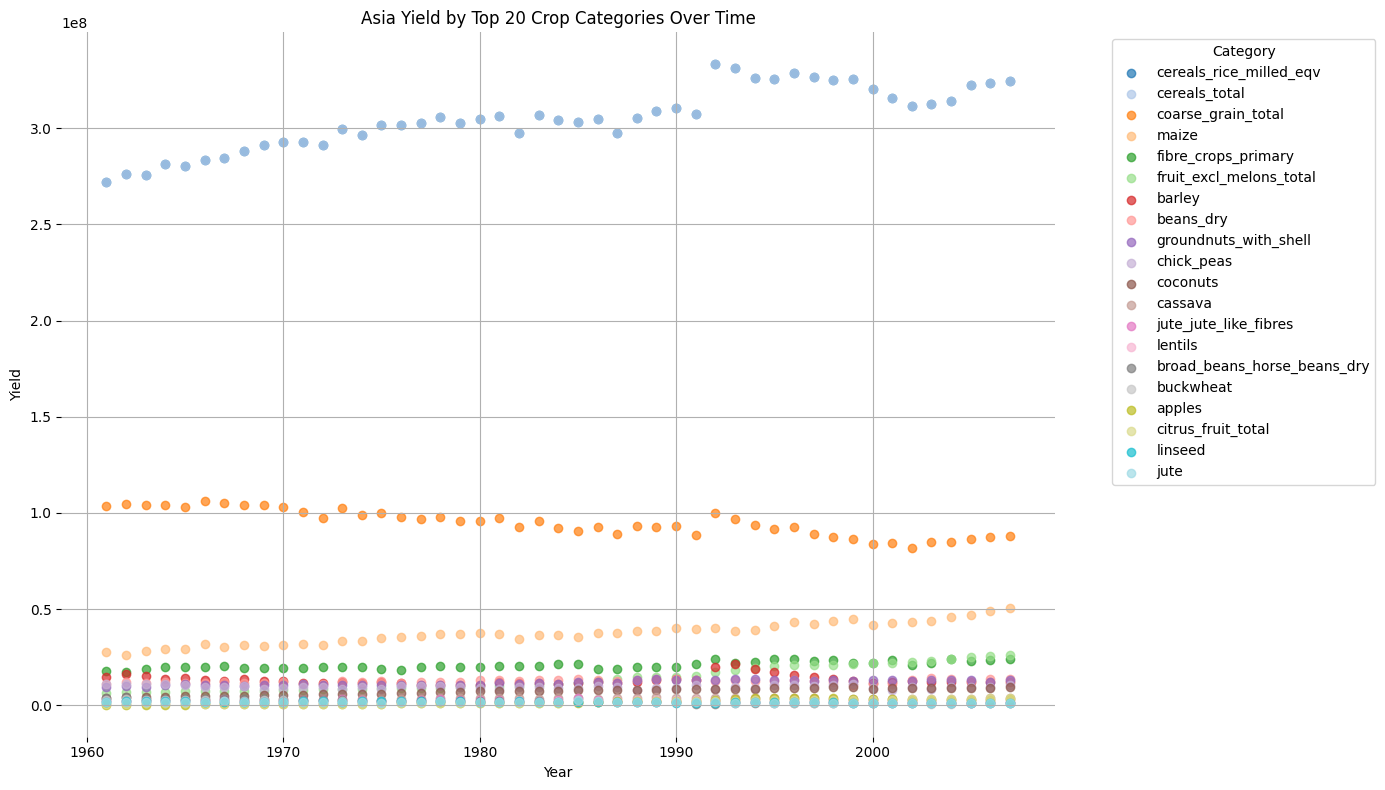

In [37]:
Asia_area_harvested = df[(df['country_or_area'] == 'Asia +') & (df['element'] == 'Yield')]
category_value_sum = china_area_harvested.groupby('category')['value'].sum()
top_20_categories = category_value_sum.nlargest(20).index
china_area_harvested_top20 = china_area_harvested[china_area_harvested['category'].isin(top_20_categories)]
colors = plt.cm.tab20.colors 

plt.figure(figsize=(14, 8))
for i, category in enumerate(top_20_categories):
    category_data = china_area_harvested_top20[china_area_harvested_top20['category'] == category]
    plt.scatter(category_data['year'], category_data['value'], color=colors[i], label=category, alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Yield')
plt.title('Asia Yield by Top 20 Crop Categories Over Time')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.grid(True)
plt.tight_layout()
ax = plt.gca()  # 获取当前坐标轴
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)  
ax.spines['bottom'].set_visible(False) 
ax.spines['left'].set_visible(False)   
plt.show()

/tmp/ipykernel_497/1717021487.py:15: UserWarning: Glyph 20040 (\N{CJK UNIFIED IDEOGRAPH-4E48}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_497/1717021487.py:15: UserWarning: Glyph 33541 (\N{CJK UNIFIED IDEOGRAPH-8305}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


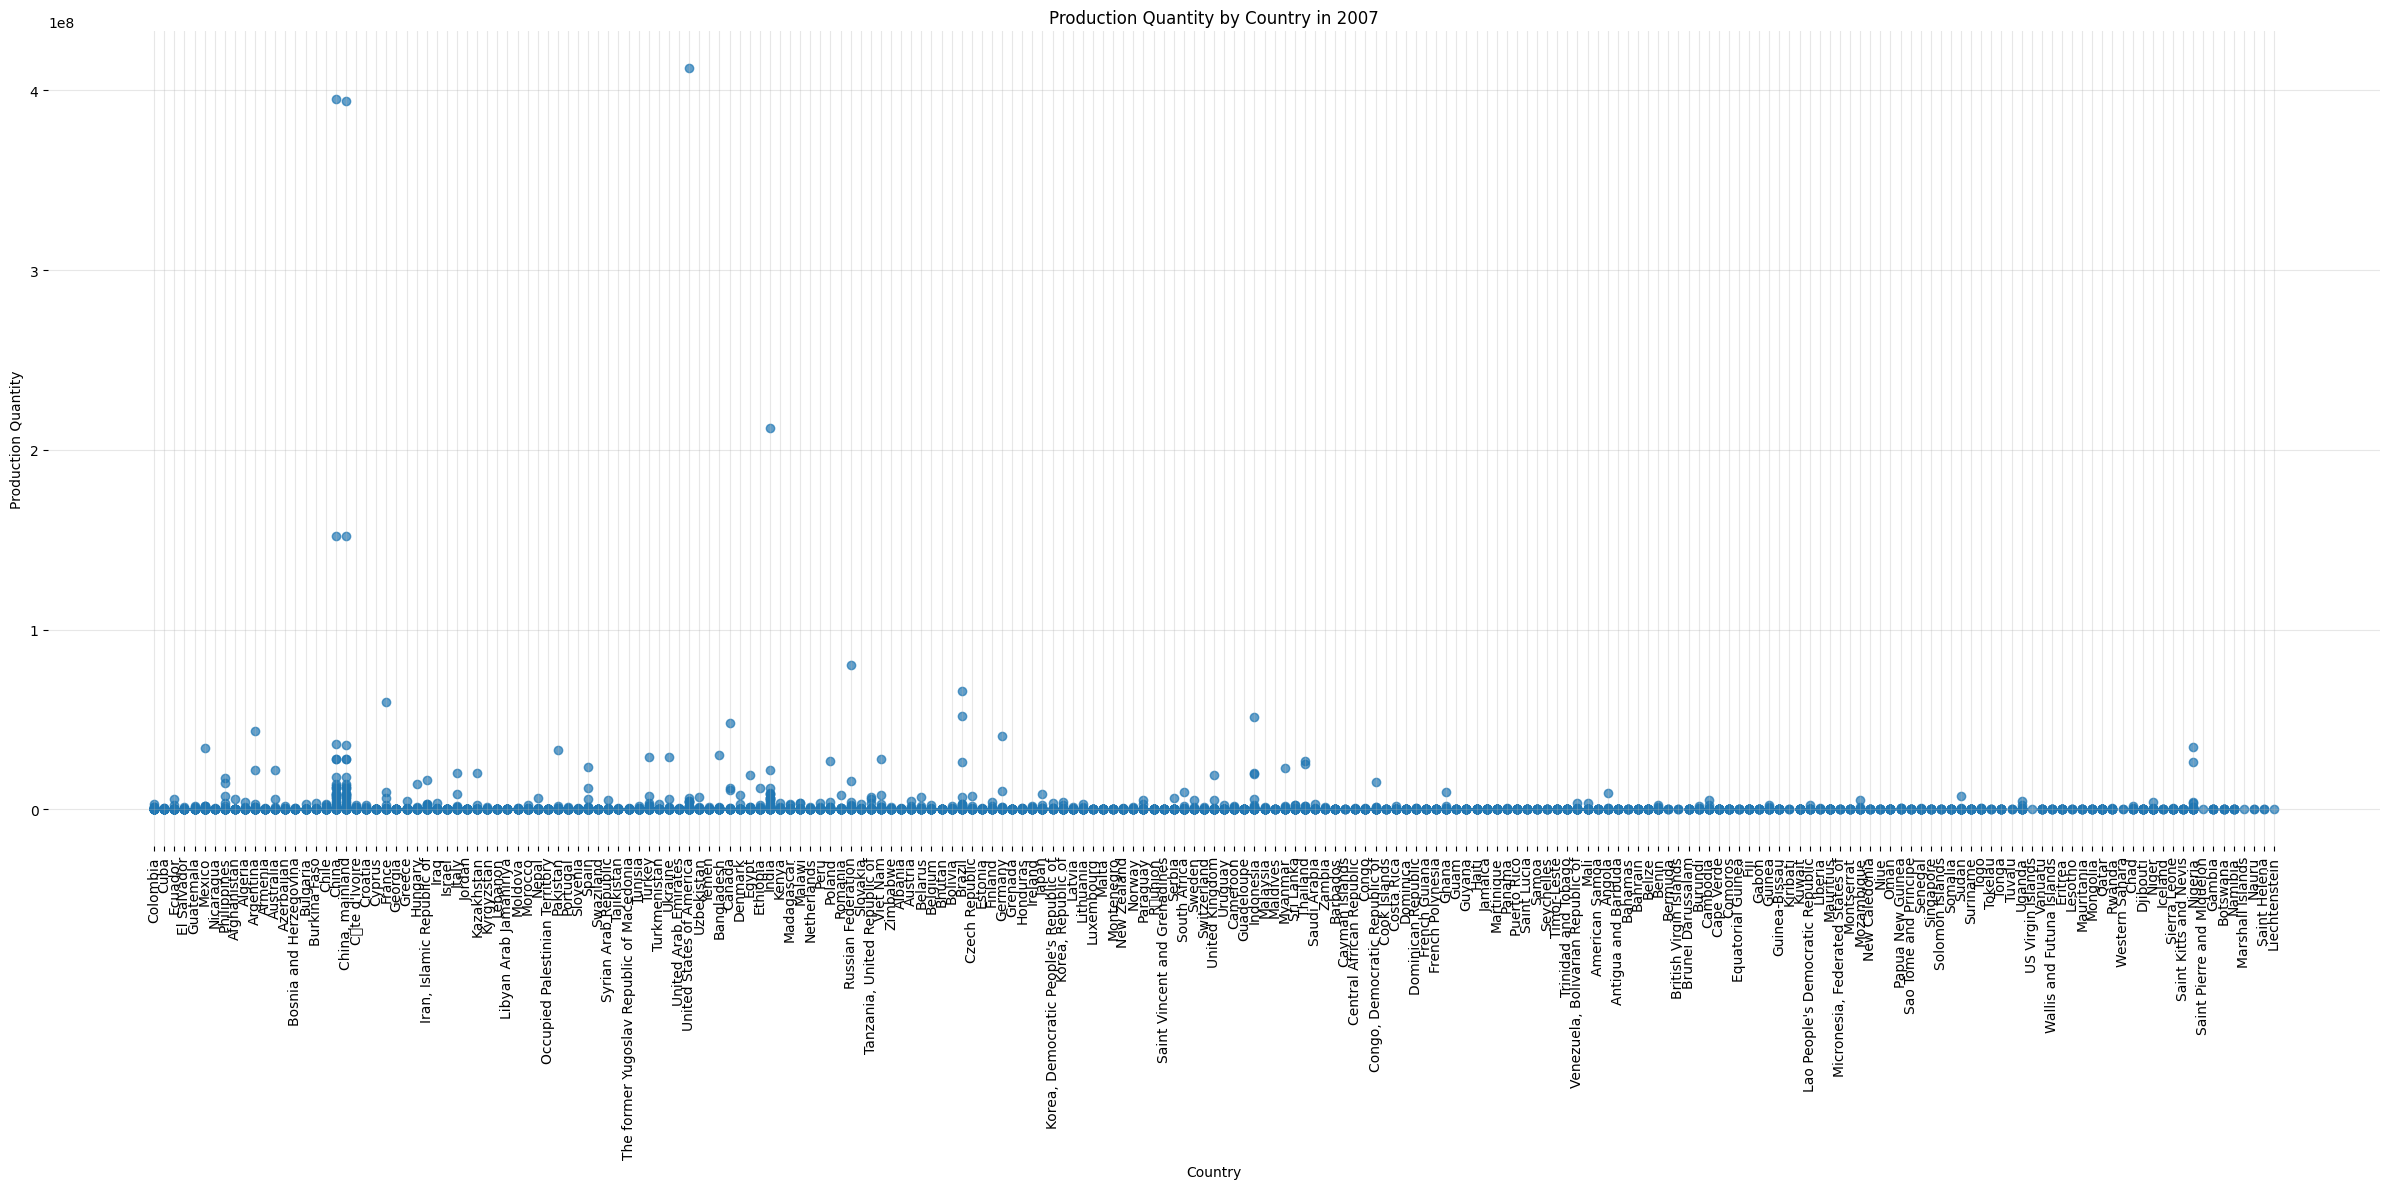

In [31]:
data_2007_total = df[
    (df['year'] == 2007) & 
    (df['element'] == 'Production Quantity') & 
    (~df['category'].str.endswith('total')) & 
    (~df['country_or_area'].str.endswith('+')) 
]

plt.figure(figsize=(24, 12))
plt.scatter(data_2007_total['country_or_area'], data_2007_total['value'], alpha=0.7)
plt.xlabel('Country')
plt.ylabel('Production Quantity')
plt.title('Production Quantity by Country in 2007')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3) 
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)  
ax.spines['bottom'].set_visible(False) 
ax.spines['left'].set_visible(False) 
plt.show()


/tmp/ipykernel_497/858987280.py:10: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.violinplot(
/tmp/ipykernel_497/858987280.py:23: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.stripplot(


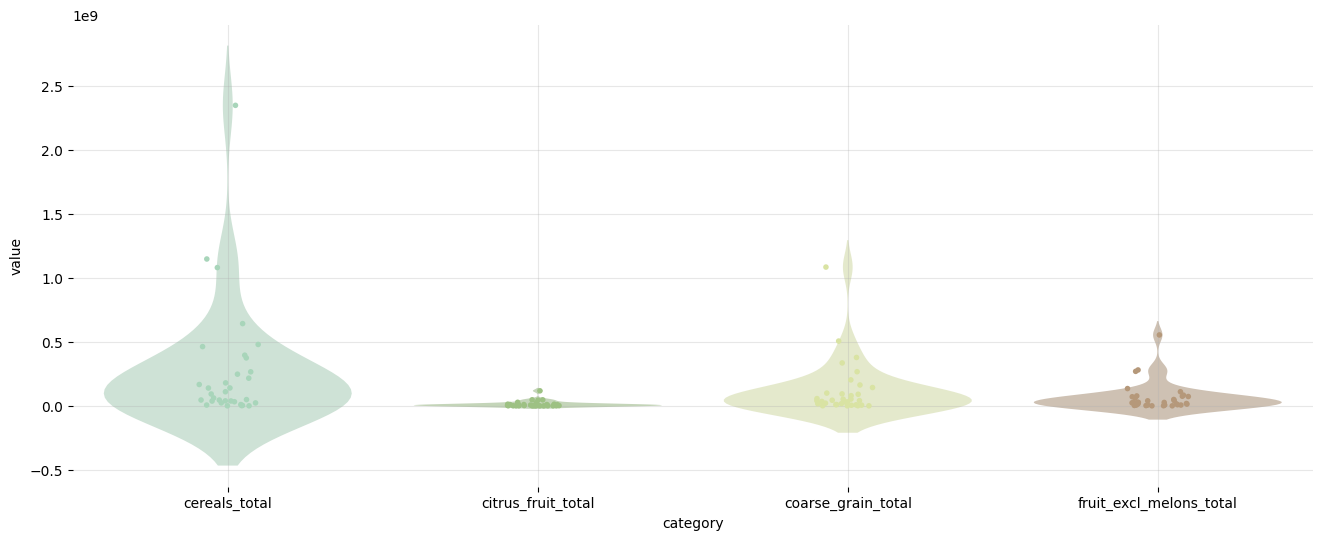

In [35]:
data_2007_total = df[
    (df['year'] == 2007) & 
    (df['element'] == 'Production Quantity') & 
    (df['category'].str.endswith('total')) & 
    (df['country_or_area'].str.endswith('+')) 
]

plt.figure(figsize=(16, 6)) 
category_order = sorted(data_2007_total['category'].unique())  

sns.violinplot(
    data=data_2007_total,
    x='category',
    y='value',
    hue='category',
    inner=None,
    density_norm='area',
    order=category_order,  
    palette=custom_palette[::5] , 
    edgecolor="none",
    alpha=0.6  
)

sns.stripplot(
    data=data_2007_total,
    x='category',
    y='value',
    hue='category',  
    order=category_order,  
    palette=custom_palette[::5],  
    linewidth=0,
    size=4
)

ax = plt.gca()  
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)  
ax.spines['bottom'].set_visible(False) 
ax.spines['left'].set_visible(False) 
plt.grid(True, alpha=0.3) 
plt.show()


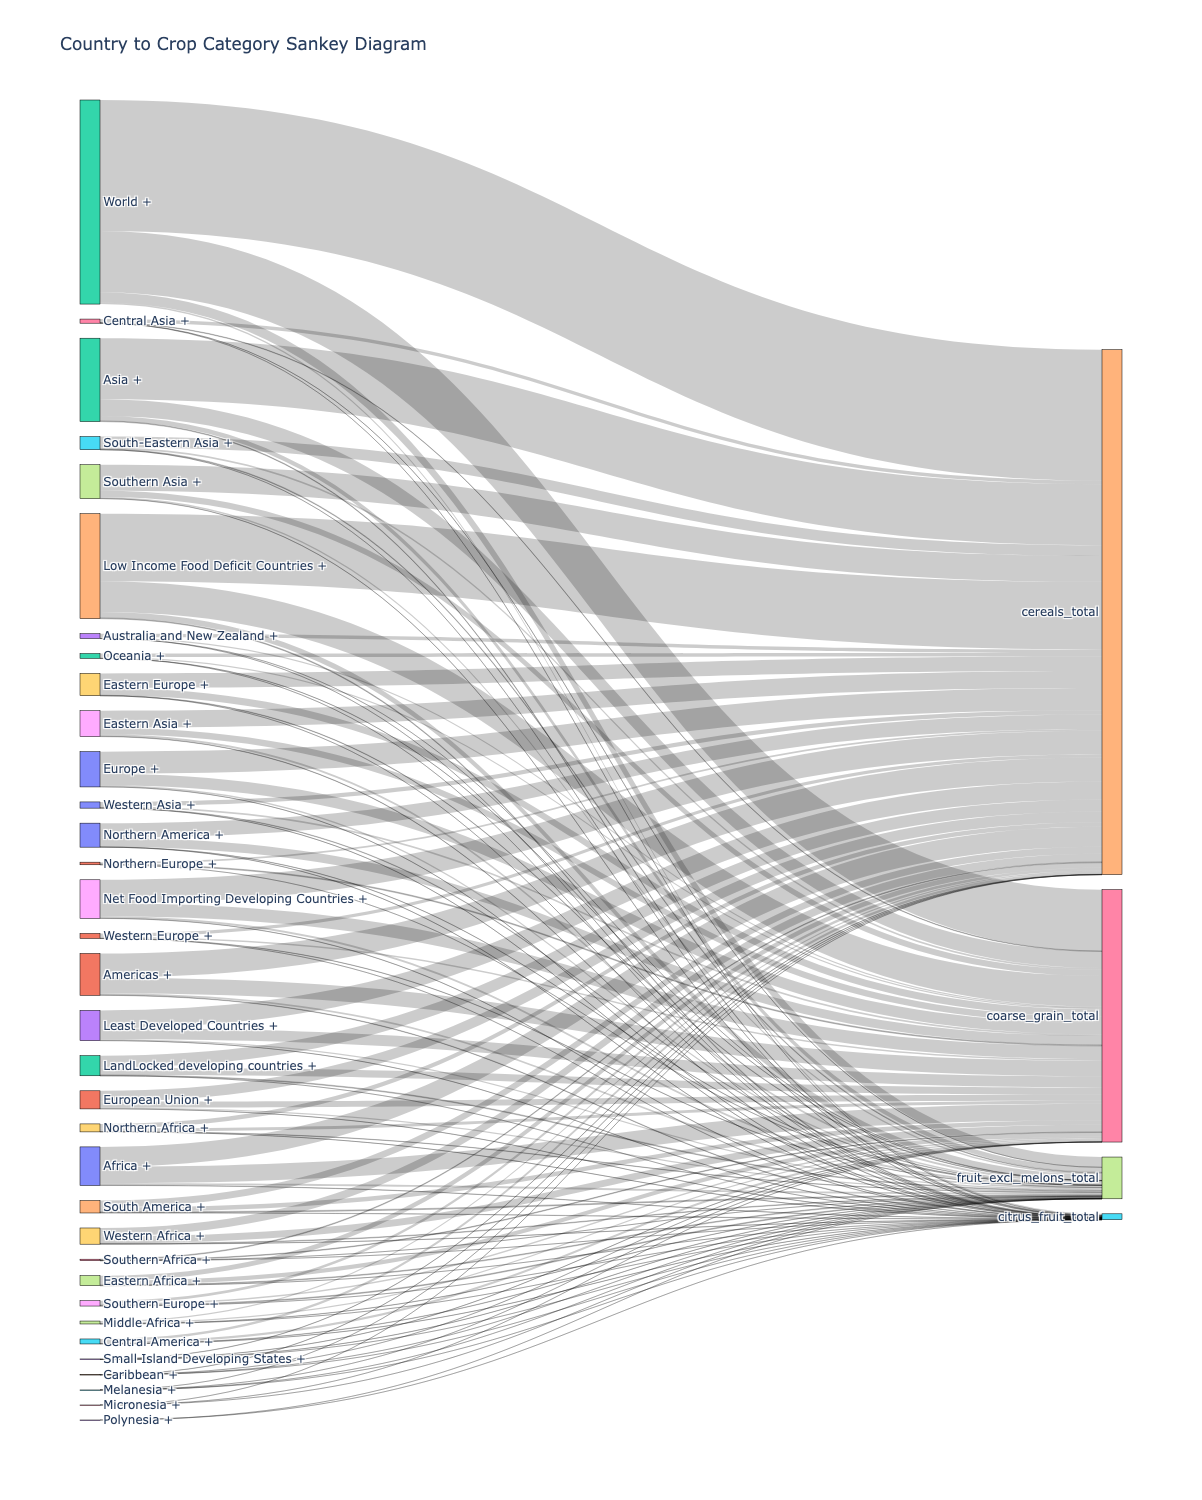

In [40]:
df_filtered = df[
    (df['year'] == 2007) & 
    (df['element'] == 'Area Harvested') & 
    (df['category'].str.endswith('total')) & 
    (df['country_or_area'].str.endswith('+')) 
]
countries = df_filtered['country_or_area'].unique().tolist()
categories = df_filtered['category'].unique().tolist()

nodes = countries + categories
node_indices = {name: i for i, name in enumerate(nodes)}

links = []
for _, row in df_filtered.iterrows():
    country = row['country_or_area']
    category = row['category']
    value = row['value']
    
    if country in node_indices and category in node_indices:
        links.append({
            'source': node_indices[country],
            'target': node_indices[category],
            'value': value
        })


fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=nodes,
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
    )
))


fig.update_layout(
    title_text="Country to Crop Category Sankey Diagram",
    font_size=12,
    width=1000,  
    height=1500  
)

fig.show()


/tmp/ipykernel_497/1258599139.py:6: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_497/1258599139.py:7: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



<Figure size 1200x600 with 0 Axes>

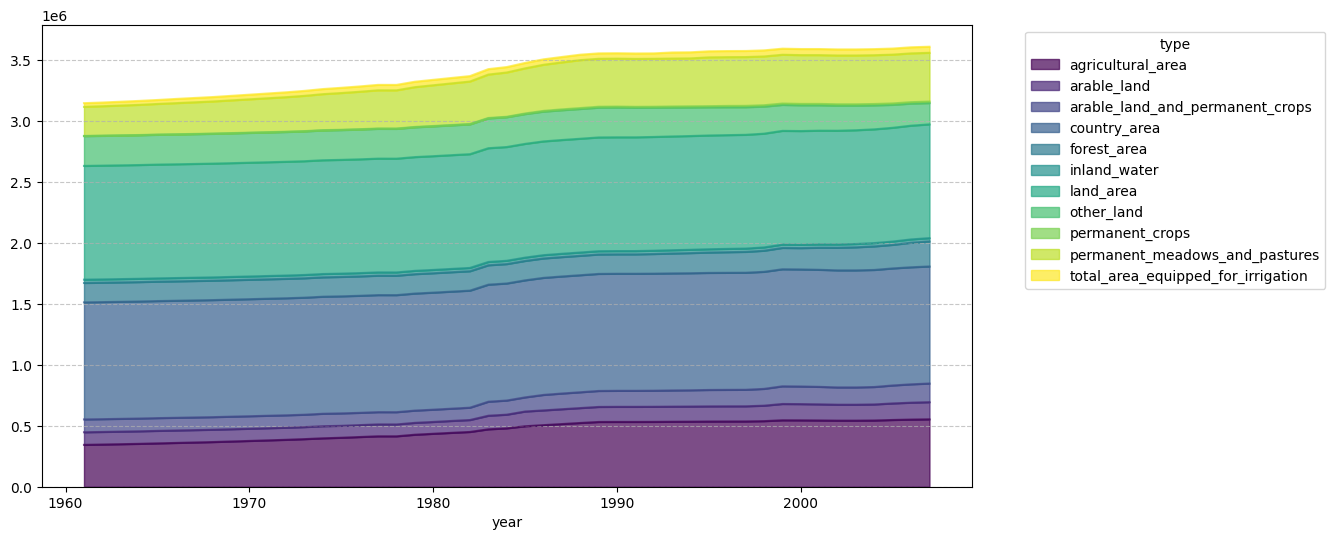

In [45]:
china_df = dfland[dfland["country_or_area"] == "China"].copy()
china_df = china_df.sort_values(by="year")
china_pivot = china_df.pivot(index="year", columns="landcategory", values="landvalue")

china_pivot.replace(0, float('nan'), inplace=True)
china_pivot.fillna(method='ffill', inplace=True)  
china_pivot.fillna(method='bfill', inplace=True) 

plt.figure(figsize=(12, 6))
china_pivot.plot.area(alpha=0.7, colormap="viridis", figsize=(12, 6))

plt.legend(title="type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()